In [1]:
import numpy as np
import pandas as pd
import datetime as dt

import matplotlib.pyplot as plt

import warnings
warnings.simplefilter("ignore")

In [8]:
#AT&T
#dataraw = pd.read_csv("HW1_Raw_ATnT.csv")
#JP Morgan
dataraw = pd.read_csv("HW1_Raw_JPMC.csv")
#Exxon
#dataraw = pd.read_csv("HW1_Raw_Exxon.csv")

In [9]:
dataraw.columns = ["PERMNO", "Date", "DeclDate", "PayDate", "RecDate", "DistCode", "DivAmount", "Price", "Volume", "HolPerReturn", "MarketReturn"]
dataraw = dataraw.drop_duplicates(subset=['PayDate'], keep='last')
dataraw["Date"] = pd.to_datetime(dataraw["Date"], format='%Y%m%d')
dataraw["DeclDate"] = pd.to_datetime(dataraw["DeclDate"], format='%Y%m%d')
dataraw["PayDate"] = pd.to_datetime(dataraw["PayDate"], format='%Y%m%d')
dataraw["RecDate"] = pd.to_datetime(dataraw["RecDate"], format='%Y%m%d')
dataraw = dataraw.sort_values(by='PayDate', ascending=True)
data = dataraw.loc[:,["Date", "DeclDate", "PayDate", "RecDate", "DivAmount", "Price", "Volume", "HolPerReturn", "MarketReturn"]].dropna().reset_index(drop = True).copy()

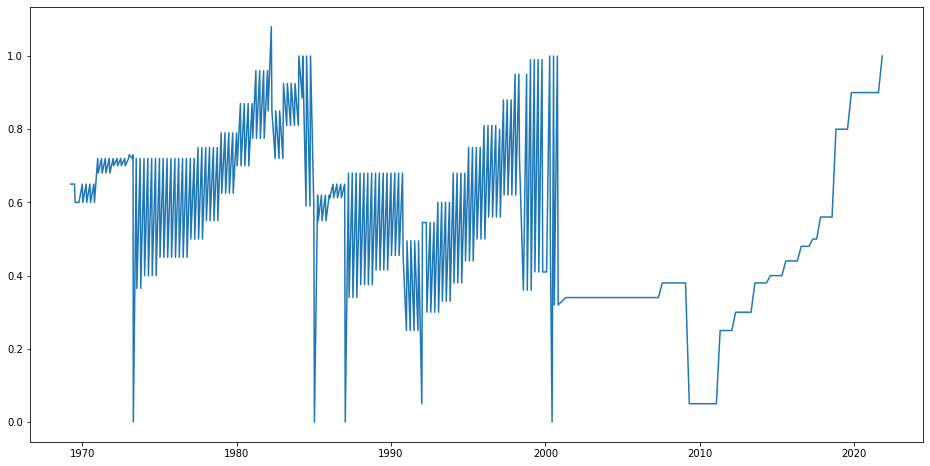

In [10]:
plt.figure(figsize = (16,8))
plt.plot(data["PayDate"], data["DivAmount"])
plt.show()